In [1]:
# CSCI-164 Machine Learning Project (Wine Classification)
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import zscore  # For outlier detection

#For Random forest
from sklearn.ensemble import RandomForestClassifier

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  wine_type             6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
None
       fixed acidity  volatile acidity  citric acid  resid

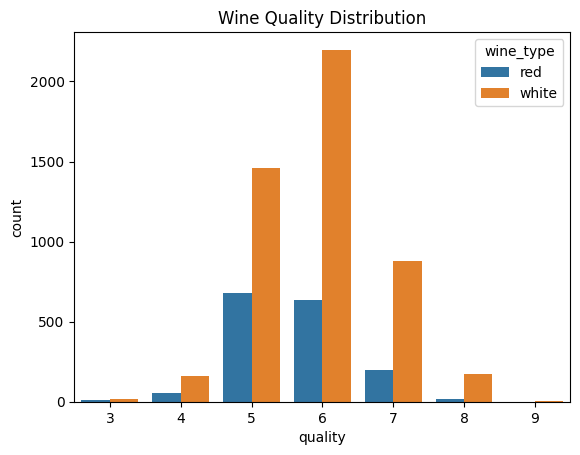

In [8]:
# Loading the datasets for red and white wine
red = pd.read_csv("/winequality-red.csv", sep=';')
white = pd.read_csv("/winequality-white.csv", sep=';')

# Add a new column to distinguish wine types
red['wine_type'] = 'red'
white['wine_type'] = 'white'

# Combine datasets
wine = pd.concat([red, white], ignore_index=True)

# Basic info (to ensure dataset is correctly loaded and check for nulls or imbalances)
print(wine.info())
print(wine.describe())
print(wine['quality'].value_counts())
print(wine.isnull().sum())

# Visualize the distribution of wine quality by wine type
sns.countplot(data=wine, x='quality', hue='wine_type')
plt.title("Wine Quality Distribution")
plt.show()

In [9]:
# Outlier Detection
numeric_data = wine.drop(['quality', 'wine_type'], axis=1)

# Compute Z-scores
z_scores = np.abs(zscore(numeric_data))

# Set threshold
threshold = 3
outliers = (z_scores > threshold).any(axis=1)

# Filter out outliers
wine_cleaned = wine[~outliers].reset_index(drop=True)

print(f"\nOriginal dataset size: {wine.shape[0]}")
print(f"Cleaned dataset size (after outlier removal): {wine_cleaned.shape[0]}")


Original dataset size: 6497
Cleaned dataset size (after outlier removal): 6009


In [10]:
# Preprocessing Data
# Use 'quality' as the multi-class label
X = wine_cleaned.drop(['quality', 'wine_type'], axis=1)
y = wine_cleaned['quality']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial Features
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# PCA on scaled data
#pca = PCA(n_components=10)
#X_train_pca = pca.fit_transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)

In [11]:
# Model training and Evaluation (baseline model)
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Baseline: Scaled only
print("=== Baseline: Standard Scaled Features ===")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# With Polynomial Features
print("\n=== With Polynomial Features ===")
for name, model in models.items():
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    print(f"\n{name} with Polynomial Features Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# With PCA
#print("\n=== With PCA (10 components) ===")
#for name, model in models.items():
#     model.fit(X_train_pca, y_train)
#     y_pred = model.predict(X_test_pca)
#     print(f"\n{name} with PCA Classification Report:")
#     print(classification_report(y_test, y_pred, zero_division=0))

=== Baseline: Standard Scaled Features ===

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.08      0.43      0.13        28
           5       0.60      0.47      0.53       421
           6       0.60      0.20      0.30       525
           7       0.29      0.29      0.29       197
           8       0.05      0.30      0.08        27
           9       0.05      1.00      0.09         1

    accuracy                           0.32      1202
   macro avg       0.24      0.38      0.20      1202
weighted avg       0.52      0.32      0.37      1202


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.15      0.14      0.15        28
           5       0.61      0.62      0.62       421
           6       0.57      0.61      0.59       525
 

In [12]:
# Hyperparameter Tuning
# Tune number of neighbors for k-NN using Grid Search
param_grid_knn = {
    'n_neighbors': list(range(1, 21, 2)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search_knn = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = param_grid_knn,
    cv=5,
    scoring = 'accuracy',
    n_jobs = -1,
    verbose = 1
)
#grid_search_knn.fit(X_train_scaled, y_train)
grid_search_knn.fit(X_train_poly, y_train)

# Output the best parameters
print("\nBest k-NN Parameters:")
print(grid_search_knn.best_params_)
print("\nBest Cross-Validated Accuracy:", grid_search_knn.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Best k-NN Parameters:
{'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}

Best Cross-Validated Accuracy: 0.6488491933861341



Logistic Regression Evaluation Metrics:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.09      0.32      0.14        28
           5       0.66      0.61      0.64       421
           6       0.63      0.38      0.48       525
           7       0.40      0.60      0.48       197
           8       0.13      0.44      0.20        27
           9       0.00      0.00      0.00         1

    accuracy                           0.50      1202
   macro avg       0.27      0.34      0.28      1202
weighted avg       0.58      0.50      0.52      1202



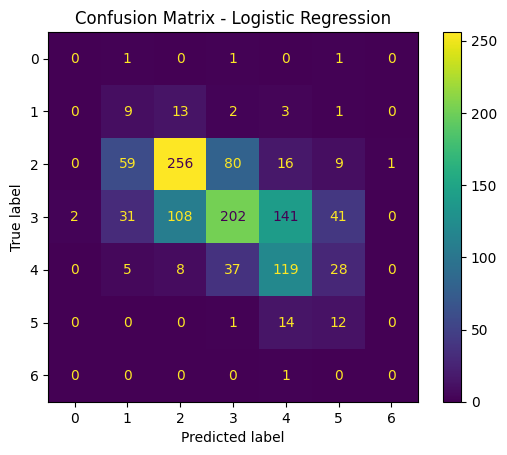

In [13]:
# Evaluation Metrics (Logistic Regression Evaluation)
final_model_logreg = models['Logistic Regression']
#y_pred_logreg = final_model_logreg.predict(X_test_scaled)
y_pred_logreg = final_model_logreg.predict(X_test_poly)

# Printing the Evaluation of the model
print("\nLogistic Regression Evaluation Metrics:")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg)
disp_logreg.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


k-NN Evaluation Metrics:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.75      0.11      0.19        28
           5       0.75      0.71      0.73       421
           6       0.65      0.77      0.70       525
           7       0.61      0.53      0.57       197
           8       0.88      0.26      0.40        27
           9       0.00      0.00      0.00         1

    accuracy                           0.68      1202
   macro avg       0.52      0.34      0.37      1202
weighted avg       0.68      0.68      0.67      1202



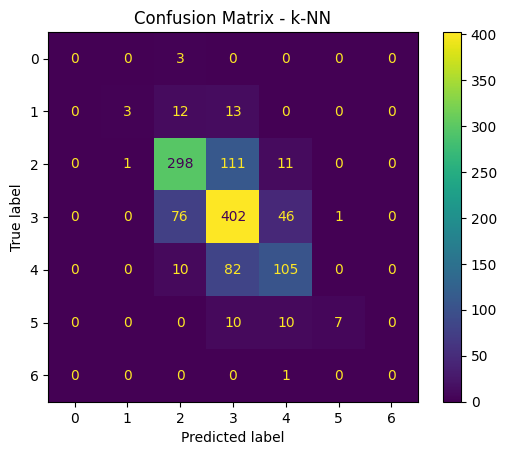

In [14]:
# Evaluation Metrics (k-NN  Evaluation)
best_knn_model = grid_search_knn.best_estimator_
#y_pred_knn = best_knn_model.predict(X_test_scaled)
y_pred_knn = best_knn_model.predict(X_test_poly)

# Printing the Evaluation of the model
print("\nk-NN Evaluation Metrics:")
print(classification_report(y_test, y_pred_knn, zero_division=0))

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()
plt.title("Confusion Matrix - k-NN")
plt.show()

Random Forest Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.44      0.14      0.22        28
           5       0.77      0.75      0.76       421
           6       0.67      0.82      0.74       525
           7       0.78      0.55      0.65       197
           8       1.00      0.30      0.46        27
           9       0.00      0.00      0.00         1

    accuracy                           0.72      1202
   macro avg       0.52      0.36      0.40      1202
weighted avg       0.72      0.72      0.71      1202



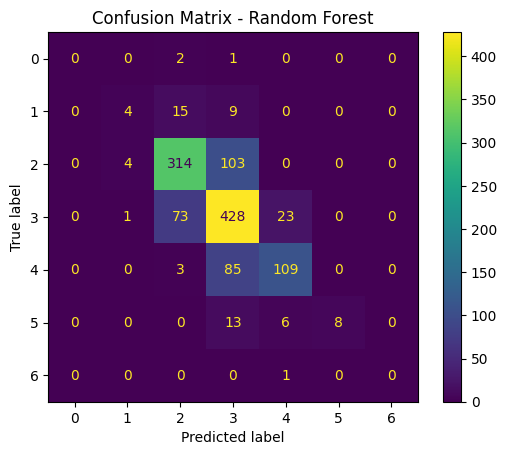

In [17]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=400,      # number of trees
    max_depth=30,        # let trees growfully
    class_weight='balanced',  # handle class imbalance
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()